# 0.0. Planejamento
##  Input
### Dados: 
* **Id**: Identificador Único;
* **Title**: Título da vaga;
* **FullDescription**: Texto completo com a descrição da vaga;
* **LocationRaw**: Texto cru da localizacao da vaga;
* **LocationNormalized**: Localizacao normalizada - **Carrega erro**;
* **ContractType**: Tipo de contrato. Indica como é o regime de horas da vaga. Pode ser:
    * full_time;
    * part_time.
* **ContractTime**: Tempo de validade do contrato. Pode ser:
    * permanent;
    * contract.
* **Company**: Nome da compania que está contratanto;
* **Category**: 30 categorias de trabalho - **Carrega erro**;
* **SalaryNormalised**: Salario anualizado da vaga. O que estamos buscando prever;
* **SourceName**: Nome to site o qual recebemos a vaga.

### Problema:
* Temos um conjunto de dados com as informacoes de vagas abertas. Com base nessas \
informacoes, devemos criar um algoritmo capaz de prever o salário em novas vagas.

## Output
* **Modelo**: Um modelo capaz de prever o salario de novos usuarios;
* **WebApp**: Um webapp que carregue esse modelo e faça previsões;
* **EDA**: Uma Análise Exploratória dos Dados e do Modelo:
    - Relatório do Modelo;
    - Relatório do Projeto.


## Tasks
1. Planejamento;
2. Ciclos;
3. Construcao do Modelo Final;
    - Métrica Principal: Mean Absolute Error (MAE)
4. Desenvolvimento do WebApp;
5. Deploy;

# 1.0. Imports

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Plot
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import HTML

# Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from xgboost import XGBRegressor

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# stats
from scipy.stats import pointbiserialr

[nltk_data] Downloading package punkt to /home/tadeu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tadeu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tadeu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    """
    
    """
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()


def cross_val_performance(X_train, y_train, model, cv):
    
    # Cross Val Train
    results = cross_validate(model, 
                             X_train, 
                             y_train, 
                             cv=cv,
                             scoring=[
                                 'neg_mean_absolute_error', 
                                 'neg_mean_absolute_percentage_error', 
                                 'neg_root_mean_squared_error'
                             ]
                            )
    
    # Performance
    mae = round(np.mean(results['test_neg_mean_absolute_error'] * -1), 2)
    mape = round(np.mean(results['test_neg_mean_absolute_percentage_error'] * -1), 4)
    rmse = round(np.mean(results['test_neg_root_mean_squared_error'] * -1), 2)
    time = round(np.mean(results['fit_time']), 2)
    
    df_results = pd.DataFrame(
                {
                    'Modelo': type(model).__name__,
                    'MAE': mae,
                    'MAPE': mape,
                    'RMSE': rmse,
                    'time': time
                },
                index=[0]
            )
    
    return df_results


def baseline_performance(y_train, n_splits):
    """
    Return a cross validation metric from the baseline model - mean
    Input:
        y_train: array with train response variables
        n_splits: number of folds
    """
    kf = KFold(n_splits=n_splits)
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for train_index, valid_index in kf.split(y_train): # split index train - valid
        
        new_y_train = y_train.iloc[train_index]
        new_y_valid = y_train.iloc[valid_index]
        
        y_hat = np.repeat(new_y_train.mean(), len(new_y_valid))
        
        mae_list.append(mean_absolute_error(new_y_valid, y_hat))
        mape_list.append(mean_absolute_percentage_error(new_y_valid, y_hat))
        rmse_list.append(sqrt(mean_squared_error(new_y_valid, y_hat)))
        
    df_results = pd.DataFrame(
                {
                    'Modelo': 'Baseline',
                    'MAE': round(np.mean(mae_list), 3),
                    'MAPE': round(np.mean(mape_list), 3),
                    'RMSE': round(np.mean(rmse_list), 3),
                    'time': 0
                },
                index=[0]
            )
    
    return df_results


def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words and remove single letters:
    tokens = [lemmatizer.lemmatize(word) for word in tokens if (word not in stop_words) and (len(word) >= 2)]

    return tokens


def count_list_series(df, column, only_values=False):
    """
    Input:
    df - pandas dataframe containing the column to be counted;
    column - columns with the list entries that must have the values counted;
    describe - if True, return count and percentage. 
    
    Output:
    df - a new dataframe containing:
        Value: the name of the variable to be counted;
        Count: count of the variable;
        Percentage: the percentage of the value in relation to the number of lines.
    """
    final_list = []
    df_aux = df[column].dropna(axis=0) # droping na values to analysis. selecting only entries with a list
    for index, value in enumerate(df_aux):
        for language in value:
            final_list.append(language)
            
    if only_values == False:
        value, counts = np.unique(final_list, return_counts=True)
        df_final = pd.DataFrame(counts, value).sort_values(by=0, ascending=False).reset_index().rename({'index': 'Value', 0: 'Count'}, axis=1)
        df_final['Percentage'] = round((100 * df_final['Count'] / len(df)), 2)
        
        return df_final
    
    else:
        
        return set(final_list)
    

def corr_words(df, x_column, y_column, list_words):

    dict_words = {}
    df_corr = df.loc[:, [x_column, y_column]]
    
    for word in list_words:            
        
        df_corr['Corr_test'] = [1 if word in row else 0 for row in df_corr[x_column] ] 
        result = pointbiserialr(df_corr['Corr_test'], df_corr[y_column])

        dict_words[word] = [result[0], result[1]]
        
    return pd.DataFrame(dict_words, index=['Corr', 'p-value']).T.sort_values(by='Corr')

Populating the interactive namespace from numpy and matplotlib


## 1.2. Data

In [3]:
data_import = pd.read_csv('../data/Train_rev1.csv')

data_import.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


# 2.0. Data Description

In [4]:
df2 = data_import.copy()

## 2.1. Shape Data

In [5]:
print(f'Rows: {df2.shape[0]}')
print(f'Columns: {df2.shape[1]}')

Rows: 244768
Columns: 12


## 2.2. Data Types

In [6]:
df2.dtypes

Id                     int64
Title                 object
FullDescription       object
LocationRaw           object
LocationNormalized    object
ContractType          object
ContractTime          object
Company               object
Category              object
SalaryRaw             object
SalaryNormalized       int64
SourceName            object
dtype: object

## 2.3. Check Na


In [7]:
tot_na = df2.isnull().sum()
percentage_na = round(df2.isnull().mean(), 4) * 100

# dataframe of na
pd.DataFrame([tot_na, percentage_na], index=['Total', 'Percentual']).T

,Total,Percentual
Id,0.0,0.00
Title,1.0,0.00
FullDescription,0.0,0.00
LocationRaw,0.0,0.00
LocationNormalized,0.0,0.00
ContractType,179326.0,73.26
ContractTime,63905.0,26.11
Company,32430.0,13.25
Category,0.0,0.00
SalaryRaw,0.0,0.00


## 2.4. Pre-Analysis

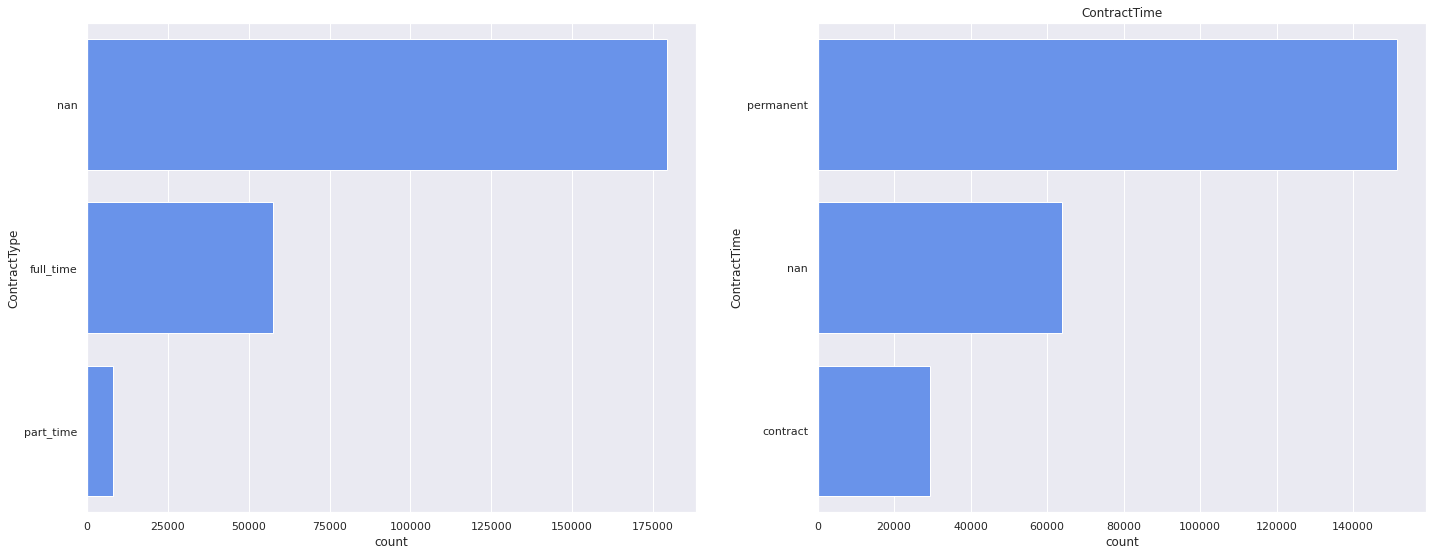

In [8]:
# Plotando colunas com poucos valores
columns = ['ContractType', 'ContractTime']

fig, ax = plt.subplots(1, 2)

for i, val in enumerate(columns):
    sns.countplot(y = df2[val].astype('str'), color='#548CFF', ax=ax[i])
    plt.title(val)

### 2.4.1. ContractType

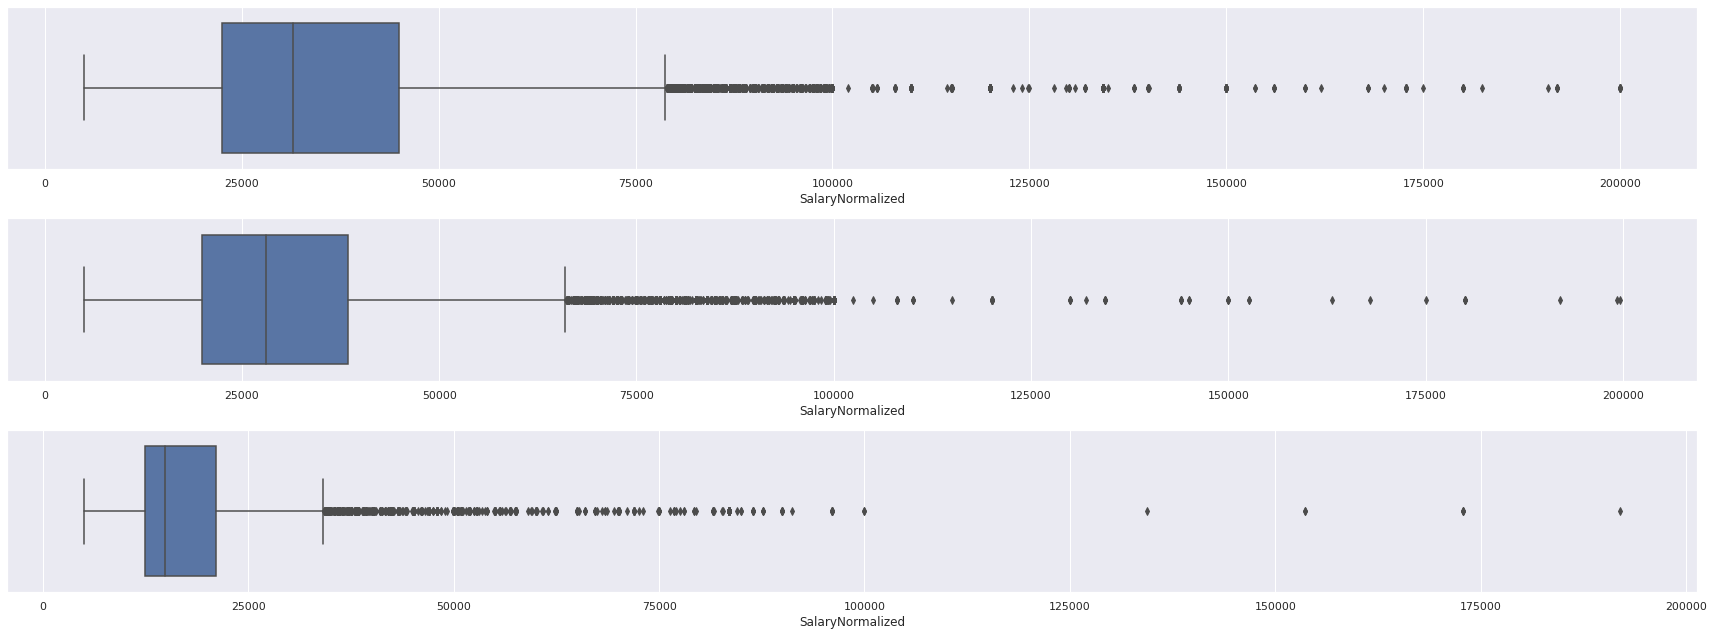

In [9]:
contract_null = df2.loc[df2['ContractType'].isnull(), 'SalaryNormalized']
contract_full = df2.loc[df2['ContractType'] == 'full_time', 'SalaryNormalized']            
contract_part = df2.loc[df2['ContractType'] == 'part_time', 'SalaryNormalized']      



fig, ax = plt.subplots(3, 1)

sns.boxplot(x=contract_null, ax=ax[0])

sns.boxplot(x=contract_full, ax=ax[1])

sns.boxplot(x=contract_part, ax=ax[2])

fig.tight_layout()

### 2.4.2. ContractTime

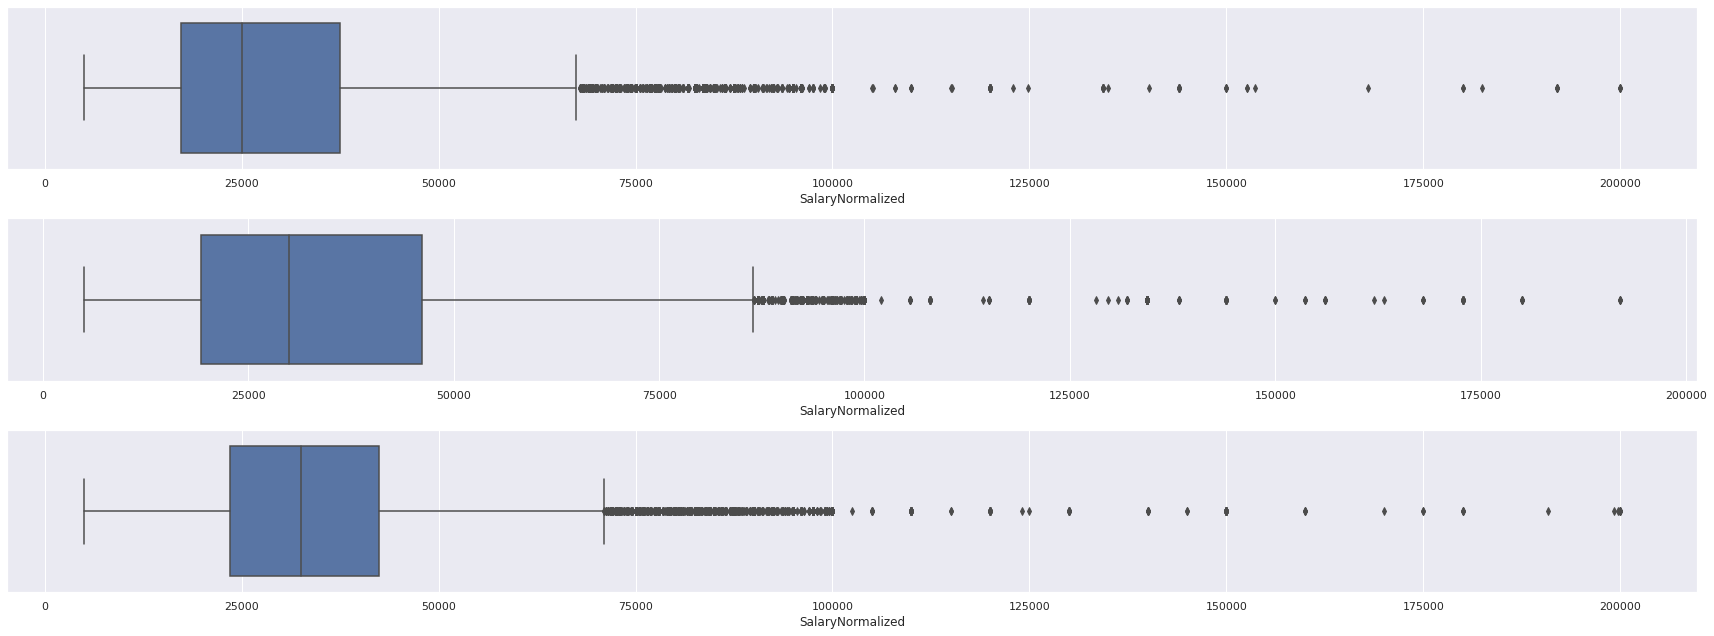

In [10]:
null = df2.loc[df2['ContractTime'].isnull(), 'SalaryNormalized']
contract = df2.loc[df2['ContractTime'] == 'contract', 'SalaryNormalized']            
permanent =  df2.loc[df2['ContractTime'] == 'permanent', 'SalaryNormalized']      



fig, ax = plt.subplots(3, 1)

sns.boxplot(x=null, ax=ax[0])
sns.boxplot(x=contract, ax=ax[1])
sns.boxplot(x=permanent, ax=ax[2])

fig.tight_layout()

# 3.0. Variable Filtering + Split

In [523]:
df3 = df2.copy()

In [524]:
df3.drop(['Id', 'LocationRaw', 'SalaryRaw', 'FullDescription', 'SourceName', 'Company', 'LocationNormalized'], axis=1, inplace=True)
df3.dropna(subset=['Title'], axis=0, inplace=True)

## 3.1. Split Dataset

In [525]:
y = df3.loc[:, 'SalaryNormalized']
X = df3.drop('SalaryNormalized', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.0. Feature Engineering

## 4.1. Title

In [526]:
# list de stop_words
stop_words = stopwords.words("english")

# instanciando o lemmatizer
lemmatizer = WordNetLemmatizer()

In [527]:
# tokenizando a coluna title
X_train['Title'] = X_train['Title'].apply(lambda x: tokenize(x))

In [528]:
# dafatrame com a contagem e porcentagem de palavras na coluna title
df_word_count = count_list_series(X_train, 'Title', only_values=False)

df_word_count.head()

,Value,Count,Percentage
0,manager,40542,20.70
1,engineer,19898,10.16
2,sale,15828,8.08
3,senior,13479,6.88
4,developer,11457,5.85


In [529]:
# juntando x e y para fazer a correlacao
#df_aux = pd.merge(X_train, y_train, right_index=True, left_index=True)

# list_words
#list_words = df_word_count['Value'].to_list()

# Criando o dataframe com as correlacoes atraves do ponto bisserial
#df_corr = corr_words(df_aux, 'Title', 'SalaryNormalized', list_words)

# salvando em csv
#df_corr.to_csv('../data/corr_title.csv')

In [530]:
# importando o dataset com as correlacoes
df_corr = pd.read_csv('../data/corr_title.csv', index_col=0).sort_values(by='Corr', ascending=False)

# transformando as correlacoes em valores absolutos
df_corr['Corr'] = df_corr['Corr'].apply(lambda x: abs(x))

# Colunas que serao usadas
cols = df_corr.loc[df_corr['Corr'] > 0.02, :].index.to_list()

# imputando as colunas
for value in cols:
    X_train[value] = X_train['Title'].apply(lambda x: 1 if value in x else 0)
    
# dropando title
X_train = X_train.drop('Title', axis=1)

/tmp/ipykernel_22190/3993504408.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[value] = X_train['Title'].apply(lambda x: 1 if value in x else 0)


# 5.0. Exploratory Data Analysis

# 6.0. Data Preparation

In [531]:
X_train_6 = X_train.copy()

## 6.1. NA Values

In [532]:
X_train_6.loc[X_train['ContractType'].isnull(), 'ContractType'] = 'null'
X_train_6.loc[X_train['ContractTime'].isnull(), 'ContractTime'] = 'null'

## 6.2. Categorical

### 6.3.1. One Hot Encoder

In [533]:
trf2 = ColumnTransformer(transformers =[
    ('enc', OneHotEncoder(sparse = False, drop ='first'), list(range(3))),
], remainder ='passthrough')

In [534]:
X_train_6 = pd.DataFrame(trf2.fit_transform(X_train_6))

# 7.0. Feature Selection

# 8.0. Machine Learning Pipeline

## 8.1. Baseline - Mean

In [535]:
base = baseline_performance(y_train, 5)

## 8.2. Linear Regression

In [536]:
lr = LinearRegression()

lr_model = cross_val_performance(X_train_6, y_train, cv=5, model=lr)

In [537]:
lr_model

,Modelo,MAE,MAPE,RMSE,time
0,LinearRegression,8827.11,0.2952,12541.95,11.45


## 8.3. DecisionTreeRegressor

In [538]:
dtr = DecisionTreeRegressor()

dtr_model = cross_val_performance(X_train_6, y_train, cv=5, model=dtr)

In [539]:
dtr_model

,Modelo,MAE,MAPE,RMSE,time
0,DecisionTreeRegressor,7795.13,0.2466,12496.88,24.17


## 8.4. Comparance

In [540]:
cross_performance = pd.concat([base, lr_model, dtr_model]).sort_values(by='MAE').reset_index(drop=True)

cross_performance

,Modelo,MAE,MAPE,RMSE,time
0,DecisionTreeRegressor,7795.130,0.2466,12496.880,24.17
1,LinearRegression,8827.110,0.2952,12541.950,11.45
2,Baseline,13404.349,0.4940,17641.462,0.00


In [541]:
# save performance
cross_performance.to_csv('../data/cross_performance_c02.csv')

# 9.0. Performance - Test Data

In [542]:
# Tokenizando
X_test['Title'] = X_test['Title'].apply(lambda x: tokenize(x))

# Transformando os tokens
for value in cols:
    X_test[value] = X_test['Title'].apply(lambda x: 1 if value in x else 0)

X_test = X_test.drop('Title', axis=1)

# Filtrando null values
X_test.loc[X_test['ContractType'].isnull(), 'ContractType'] = 'null'
X_test.loc[X_test['ContractTime'].isnull(), 'ContractTime'] = 'null'

# Transformando as colunas em binarias
trf2 = ColumnTransformer(transformers =[
    ('enc', OneHotEncoder(sparse = False, drop ='first'), list(range(3))),
], remainder ='passthrough')

X_test = pd.DataFrame(trf2.fit_transform(X_test))

/tmp/ipykernel_22190/1741058283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[value] = X_test['Title'].apply(lambda x: 1 if value in x else 0)


In [543]:
dtr = DecisionTreeRegressor()

dtr.fit(X_train_6, y_train)

y_hat = dtr.predict(X_test)

In [544]:
mean_absolute_error(y_test, y_hat)

7611.210705536943

# 10.0. Deploy